# Sistemas de Múltiplos Classificadores

## 1)

Selecione cinco bases de dados públicas que contenham características diferentes e, para cada base, calcule o Oracle no conjunto de teste para:
* Bagging
* Adaboost 
* Random Subspace (50%)
* Random Oracles

variando o número de classificadores-base {10, 20, …, 100}. 

Use o Perceptron como classificador-base e divida os fold usando o 5-fold cross-validation. 

Analise os resultados. 

### Dados

1. 

2. 

3. 

4. 

5. 

In [7]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier # servirá para o Bagging e para o Random Subspace
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaseEnsemble
from rlo import RLO

import oracle

In [2]:
np.random.seed(111)

#### Implementação do RLO 

In [ ]:
class RLO(BaseEnsemble):
    
    def __init__(self,
                 base_estimator=None,
                 n_estimators=10,
                 E = None,
                 H = None,
                ):
        super().__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators)
        
            
    def fit(self, X, y):
        N = X.shape[0]
        self.E = {f'D_{i}':{'left:':None, 'right':None} for i in range(self.n_estimators)}
        self.H = {f'H_{i}':None for i in range(self.n_estimators)}
        
        for i in range(self.n_estimators):
            while True:
                try:
                    rp = np.random.choice(N, 2)
                    A, B = X[rp[0], :], X[rp[1], :]
                    self.H[f'H_{i}'] = np.hstack((A - B, (B@B.T - A@A.T)/2))
                    left = np.hstack((X, np.ones((N, 1)))) @ self.H[f'H_{i}'].T > 0
                    classificador_left = self.base_estimator
                    classificador_right = self.base_estimator
                    self.E[f'D_{i}']['left'] = classificador_left.fit(X[left, :], y[left])
                    self.E[f'D_{i}']['right'] = classificador_right.fit(X[~left, :], y[~left])
                    
                    break
                except:
                    continue
                break

        return self.E, self.H
#         return (E, H)

    def predict(self, X, y):

        L = len(self.E)
        ens = np.zeros((X.shape[0], L))

        for i in range(L):
            left = np.hstack((X, np.ones((X.shape[0], 1)))) @ self.H[f'H_{i}'].T > 0
            ens[left, i] = self.E[f'D_{i}']['left'].predict(X[left, :])
            ens[~left, i] = self.E[f'D_{i}']['right'].predict(X[~left, :])

        a1 = stats.mode(ens.T)[0]
        e = np.mean(a1 != y)

        return (ens, a1, e)
    
    def Oracle_predict(self, X, y):
        predictions, _, _ = self.predict(X, y)
        pred_oracle = np.any((predictions == y.reshape(-1,1)), axis=1)
        return pred_oracle
    
    def Oracle_score(self, X, y):
        pred_oracle = self.Oracle_predict(X, y)
        acc_oracle = pred_oracle.sum() / pred_oracle.shape[0]
        return acc_oracle

In [ ]:
# ## Implementação do Random Linear Oracle (RLO) baseado no livro de Kuncheva



# def rlo_train(X, y, L, modelo):
#     N = X.shape[0]
#     E = {f'D_{i}':{'left:':None, 'right':None} for i in range(L)}
#     H = {f'H_{i}':None for i in range(L)}
    
#     for i in range(L):
#         rp = np.random.choice(N, 2)
#         A, B = X[rp[0], :], X[rp[1], :]
#         H[f'H_{i}'] = np.hstack((A - B, (B@B.T - A@A.T)/2))
#         left = np.hstack((X, np.ones((N, 1)))) @ H[f'H_{i}'].T > 0
#         classificador_left = modelo
#         classificador_right = modelo
#         E[f'D_{i}']['left'] = classificador_left.fit(X[left, :], y[left])
#         E[f'D_{i}']['right'] = classificador_right.fit(X[~left, :], y[~left])

#     return (E, H)

# def rlo_classificar(E, H, X, y):
    
#     L = len(E)
#     ens = np.zeros((X.shape[0], L))
    
#     for i in range(L):
#         left = np.hstack((X, np.ones((X.shape[0], 1)))) @ H[f'H_{i}'].T > 0
#         ens[left, i] = E[f'D_{i}']['left'].predict(X[left, :])
#         ens[~left, i] = E[f'D_{i}']['right'].predict(X[~left, :])
    
#     a1 = stats.mode(ens.T)[0]
#     e = np.mean(a1 != y)
    
#     return (a1, e)
    

In [3]:
# número de classificadores base
n_classificadores_base = np.arange(10, 110, 10)
print(n_classificadores_base)

[ 10  20  30  40  50  60  70  80  90 100]


In [4]:
## Base de dados para teste
data = load_breast_cancer()
X = data.data
y = data.target
# # split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Scale the variables to have 0 mean and unit variance
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

# # Split the data into training and DSEL for DS techniques
# X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)

#### Testando o RLO

In [9]:
cls_base = Perceptron(max_iter=10)
rlo = RLO(base_estimator=cls_base, n_estimators=3)

# treinar
rlo.fit(X_train, y_train)

# testar 
predictions, pred_ens, erro = rlo.predict(X_test, y_test)

/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [10]:
erro_rlo = np.mean(pred_ens == y_test)
print(erro_rlo)

0.9627659574468085


In [11]:
# Oracle
# pred_oracle = np.any((predictions == y_dsel.reshape(-1,1)), axis=1)
# acc_oracle = pred_oracle.sum()/pred_oracle.shape[0]
# print(f'acc Oracle: {acc_oracle}')
pred_oracle = rlo.Oracle_predict(X_test, y_test)
acc_oracle = rlo.Oracle_score(X_test, y_test)

In [12]:
print(f'Oracle Accuracy: {acc_oracle}')

Oracle Accuracy: 0.9627659574468085


#### função que faz a Validação cruzada 5fold com o RLO
#### função avalia_L_modelos para o RLO 

In [13]:
# Criando os 5 folds e salvando em dicionário
def cria_folds(X, y, n=5):
    kf = StratifiedKFold(n_splits=n)
    kfolds = dict()
    i = 1
    for train_index, test_index in kf.split(X, y):
        kfolds[f'fold{i}'] = (train_index, test_index)
        i += 1
    return kfolds

In [14]:
# criando os 5-folds
kfolds = cria_folds(X_train,y_train,n=5)

In [15]:
## função cv RLO
def cv_RLO(kfolds, RLO, X, y):
    '''
    Realiza a validação cruzada para um Random Linear Oracle.
    
    Retorna uma tupla com dois dicionários: modelos e resultados.
    '''
    modelos = dict.fromkeys(kfolds)
    resultados = dict.fromkeys(kfolds)
    
    for fold, (train_idx, test_idx) in kfolds.items():
        modelo = RLO
        _,_ = modelo.fit(X[train_idx], y[train_idx])
        modelos[fold] = modelo
#         resultados[fold] = modelo.predict(X[test_idx], y[test_idx])
        resultados[fold] = modelo.predict(X[train_idx], y[train_idx])
    
    return (modelos, resultados)
    

## função avalia_L_modelos_RLO
def avalia_cv_RLO(kfolds, modelos_cv, X, y):
    '''
    Realiza a avaliação dos resultados para os dados de teste para o Random Linear Oracle e computa o Oracle para o conjunto de teste
    
    Retorna uma tupla com dois dicionários: resultados, oracles
    '''
    
    resultados = dict.fromkeys(modelos_cv)
    oracles = dict.fromkeys(modelos_cv)
    for fold, (_, test_idx) in kfolds.items():
        resultados[fold] = modelos_cv[fold].predict(X[test_idx], y[test_idx])
        oracles[fold] = modelos_cv[fold].Oracle_score(X[test_idx], y[test_idx])
    return (resultados, oracles)

In [16]:
modelos_cv, resultados_treinamento_cv = cv_RLO(kfolds, rlo, X_train, y_train)
resultados_teste_cv, oracles_cv = avalia_cv_RLO(kfolds, modelos_cv, X_train, y_train)

/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Conv

In [17]:
## Mostrando Oracle para cada fold
print("Acurácia do Oracle para cada Fold:")
oracles_cv

Acurácia do Oracle para cada Fold:


{'fold1': 0.974025974025974,
 'fold2': 0.9473684210526315,
 'fold3': 0.9605263157894737,
 'fold4': 0.8947368421052632,
 'fold5': 0.9605263157894737}

In [18]:
### Realizando o procedimento anterior variando agora a quantidade de classificadores do modelo

### quantidade de classificadores
n_classificadores = np.arange(10, 110, 10)

## criando dicionário par receber os resultados para treinamento e teste
rlo_classificadores_resultados_treinamento = dict.fromkeys(n_classificadores)
rlo_classificadores_resultados_teste = dict.fromkeys(n_classificadores)

## Loop para cada n dos L classificadores
for n in n_classificadores:
    ## treinamento
    modelos, resultados = cv_RLO(kfolds, rlo, X_train, y_train)
    rlo_classificadores_resultados_treinamento[n] = (modelos, resultados)
    ## avalia cv 
    resultados_teste, oracles_teste = avalia_cv_RLO(kfolds, modelos, X_train, y_train)
    rlo_classificadores_resultados_teste[n] = (resultados_teste, oracles_teste)
    

/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Conv

In [19]:
rlo_classificadores_resultados_treinamento.keys()

dict_keys([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [21]:
## Avaliando Oracle para cada n

rlo_oracles = dict.fromkeys(n_classificadores)
for n in n_classificadores:
    oracles_n = []
    for i in range(1,6):
        fold = f'fold{i}'
        oracle_i = rlo_classificadores_resultados_teste[n][1][fold]
        oracles_n.append(oracle_i)
    rlo_oracles[n] = oracles_n
# for n in n_classificadores:
#     print(rlo_classificadores_resultados_teste[n][1]['fold2'])

In [22]:
## Transformando em DataFrame
rlo_oracle_df = pd.DataFrame(rlo_oracles)
## Calculando estatísticas
rlo_oracle_df.describe()

10        20        30        40        50        60        70   \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.931716  0.968455  0.976316  0.973684  0.960629  0.960560  0.963226   
std    0.017315  0.015055  0.019516  0.020804  0.013160  0.018669  0.011091   
min    0.907895  0.947368  0.947368  0.947368  0.947368  0.934211  0.947368   
25%    0.921053  0.960526  0.973684  0.960526  0.947368  0.960526  0.960526   
50%    0.934211  0.973684  0.973684  0.973684  0.961039  0.960526  0.960526   
75%    0.947368  0.973684  0.986842  0.986842  0.973684  0.960526  0.973684   
max    0.948052  0.987013  1.000000  1.000000  0.973684  0.987013  0.974026   

            80        90        100  
count  5.000000  5.000000  5.000000  
mean   0.976350  0.968489  0.944839  
std    0.011050  0.007271  0.021715  
min    0.960526  0.960526  0.921053  
25%    0.973684  0.960526  0.921053  
50%    0.973684  0.973684  0.960526  
75%    0.986842  0.973684  0.960526  
max    0.987013  0.974026  0.961039

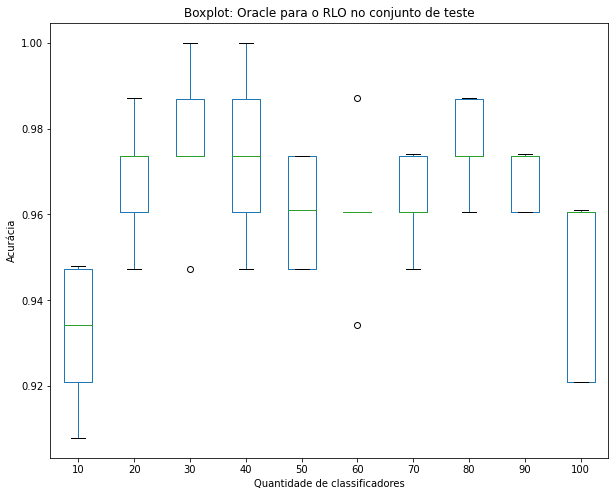

In [23]:
rlo_oracle_df.boxplot(figsize=(10,8), grid=False)
plt.title('Boxplot: Oracle para o RLO no conjunto de teste')
plt.xlabel('Quantidade de classificadores')
plt.ylabel('Acurácia')
plt.show();

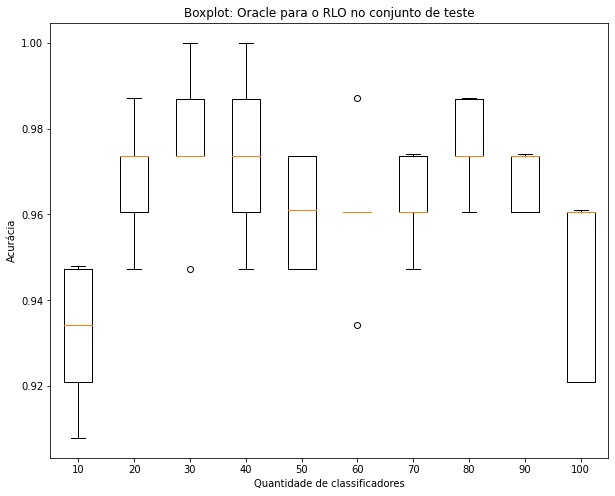

In [24]:
plt.figure(figsize=(10,8))
plt.boxplot(rlo_oracles.values(), labels=rlo_oracles.keys())
plt.title('Boxplot: Oracle para o RLO no conjunto de teste')
plt.xlabel('Quantidade de classificadores')
plt.ylabel('Acurácia')
plt.show();

### Implementar funções para os demais modelos

In [26]:
# função para criar os classificadores com o Perceptron como classificador base
def L_modelos(classificador, random_subspace=False):
    if random_subspace:
        max_features = 0.5 # 50% de features
        modelos = dict()
        n_classificadores = np.arange(10, 110, 10)
        for n in n_classificadores:
            modelos[str(n)] = classificador(CalibratedClassifierCV(Perceptron(max_iter=10)), 
                                            n_estimators = n, 
                                            max_features=max_features)
        
    else:
        max_features = 1.0
        
        modelos = dict()
        n_classificadores = np.arange(10, 110, 10)
        for n in n_classificadores:
            modelos[str(n)] = classificador(CalibratedClassifierCV(Perceptron(max_iter=10)), 
                                            n_estimators = n)
        
    return modelos

# função para realizar a validação cruzada dos classificadores 
def avalia_L_modelos(L_classificadores, X, y, kfolds):
    
    # criando dicionário para receber os scores
    scores = dict.fromkeys(kfolds.keys())
    
    # loop para criar os folds
    for fold, (id_train, id_test) in kfolds.items():
        print(fold)
        X_train, X_test = X[id_train], X[id_test]
        y_train, y_test = y[id_train], y[id_test]
        
        # criar dicionário para receber os scores dos folds
        scores_L = dict.fromkeys(L_classificadores)
        # loop para realizar treinamento e classificação
        for classificador in L_classificadores:
            print('Qtd. classificadores: ', classificador)
            L_classificadores[classificador].fit(X_train, y_train)
            pred = L_classificadores[classificador].predict(X_test)
            scores_L[classificador] = {'accuracy': accuracy_score(y_test, pred), 
                                       'modelo': L_classificadores[classificador]}
        
        # armazenar score para os L_classificadores
        scores[fold] = scores_L
        
    return scores
    

In [ ]:
# criando os L classificadores
modelos_L = L_modelos(BaggingClassifier)

# avaliando por validação cruzada
bagging_classifier_cv = avalia_L_modelos(modelos_L, X_train, y_train, kfolds)

fold1
Qtd. classificadores:  10


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  20


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  30


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: Converge

Qtd. classificadores:  40


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  50


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  60


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  70


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/pytho

Qtd. classificadores:  80


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  90


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  100


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

fold2
Qtd. classificadores:  10


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  20


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  30


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/pytho

Qtd. classificadores:  40


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  50


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to 

Qtd. classificadores:  60


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/pytho

Qtd. classificadores:  70


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  80


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/pytho

Qtd. classificadores:  90


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  100


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

fold3
Qtd. classificadores:  10


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to 

Qtd. classificadores:  20


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  30


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  40


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  50


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  60


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/pytho

Qtd. classificadores:  70


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  80


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  90


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  100


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

fold4
Qtd. classificadores:  10


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  20


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  30


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to 

Qtd. classificadores:  40


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  50


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  60


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/pytho

Qtd. classificadores:  70


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

Qtd. classificadores:  80


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to 

Qtd. classificadores:  90


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  100


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply

fold5
Qtd. classificadores:  10


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  20


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum num

Qtd. classificadores:  30


/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/python3.7/site-packages/sklearn/calibration.py:436: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
/mnt/sdb1/discohd/miniconda3/lib/pytho

Qtd. classificadores:  40


In [ ]:
print('média:         ',np.mean([bagging_classifier_cv[f'fold{i}']['10']['accuracy'] for i in range(1, 6)]))
print('desvio padrão: ', np.std([bagging_classifier_cv[f'fold{i}']['10']['accuracy'] for i in range(1, 6)], ddof=1))

In [ ]:
# mostrando a accuracy para cada fold para todos os n classificadores
print('10: ', [bagging_classifier_cv[f'fold{i}']['10']['accuracy'] for i in range(1, 6)])
print('20: ',[bagging_classifier_cv[f'fold{i}']['20']['accuracy'] for i in range(1, 6)])
print('30: ',[bagging_classifier_cv[f'fold{i}']['30']['accuracy'] for i in range(1, 6)])
print('40: ',[bagging_classifier_cv[f'fold{i}']['40']['accuracy'] for i in range(1, 6)])
print('50: ',[bagging_classifier_cv[f'fold{i}']['50']['accuracy'] for i in range(1, 6)])
print('60: ',[bagging_classifier_cv[f'fold{i}']['60']['accuracy'] for i in range(1, 6)])
print('70: ',[bagging_classifier_cv[f'fold{i}']['70']['accuracy'] for i in range(1, 6)])
print('80: ',[bagging_classifier_cv[f'fold{i}']['80']['accuracy'] for i in range(1, 6)])
print('90: ',[bagging_classifier_cv[f'fold{i}']['90']['accuracy'] for i in range(1, 6)])
print('100: ',[bagging_classifier_cv[f'fold{i}']['100']['accuracy'] for i in range(1, 6)])

In [ ]:
# Adaboost
# criando os L classificadores
modelos_L_adaboost = L_modelos(AdaBoostClassifier)

adaboost_classifier_cv = avalia_L_modelos(modelos_L_adaboost, X_train, y_train, kfolds)

In [ ]:
print('média:         ',np.mean([adaboost_classifier_cv[f'fold{i}']['10']['accuracy'] for i in range(1, 6)]))
print('desvio padrão: ', np.std([adaboost_classifier_cv[f'fold{i}']['10']['accuracy'] for i in range(1, 6)], ddof=1))

In [ ]:
# mostrando a accuracy para cada fold para todos os n classificadores
print('10: ', [adaboost_classifier_cv[f'fold{i}']['10']['accuracy'] for i in range(1, 6)])
print('20: ',[adaboost_classifier_cv[f'fold{i}']['20']['accuracy'] for i in range(1, 6)])
print('30: ',[adaboost_classifier_cv[f'fold{i}']['30']['accuracy'] for i in range(1, 6)])
print('40: ',[adaboost_classifier_cv[f'fold{i}']['40']['accuracy'] for i in range(1, 6)])
print('50: ',[adaboost_classifier_cv[f'fold{i}']['50']['accuracy'] for i in range(1, 6)])
print('60: ',[adaboost_classifier_cv[f'fold{i}']['60']['accuracy'] for i in range(1, 6)])
print('70: ',[adaboost_classifier_cv[f'fold{i}']['70']['accuracy'] for i in range(1, 6)])
print('80: ',[adaboost_classifier_cv[f'fold{i}']['80']['accuracy'] for i in range(1, 6)])
print('90: ',[adaboost_classifier_cv[f'fold{i}']['90']['accuracy'] for i in range(1, 6)])
print('100: ',[adaboost_classifier_cv[f'fold{i}']['100']['accuracy'] for i in range(1, 6)])

In [ ]:
## random subspace
# criando os L classificadores
modelos_L_random_subspace = L_modelos(BaggingClassifier, True)

random_subspace_classifier_cv = avalia_L_modelos(modelos_L_random_subspace, X_train, y_train, kfolds)

In [ ]:
print('média:         ',np.mean([random_subspace_classifier_cv[f'fold{i}']['10']['accuracy'] for i in range(1, 6)]))
print('desvio padrão: ', np.std([random_subspace_classifier_cv[f'fold{i}']['10']['accuracy'] for i in range(1, 6)], ddof=1))

In [ ]:
# mostrando a accuracy para cada fold para todos os n classificadores
print('10: ', [random_subspace_classifier_cv[f'fold{i}']['10']['accuracy'] for i in range(1, 6)])
print('20: ',[random_subspace_classifier_cv[f'fold{i}']['20']['accuracy'] for i in range(1, 6)])
print('30: ',[random_subspace_classifier_cv[f'fold{i}']['30']['accuracy'] for i in range(1, 6)])
print('40: ',[random_subspace_classifier_cv[f'fold{i}']['40']['accuracy'] for i in range(1, 6)])
print('50: ',[random_subspace_classifier_cv[f'fold{i}']['50']['accuracy'] for i in range(1, 6)])
print('60: ',[random_subspace_classifier_cv[f'fold{i}']['60']['accuracy'] for i in range(1, 6)])
print('70: ',[random_subspace_classifier_cv[f'fold{i}']['70']['accuracy'] for i in range(1, 6)])
print('80: ',[random_subspace_classifier_cv[f'fold{i}']['80']['accuracy'] for i in range(1, 6)])
print('90: ',[random_subspace_classifier_cv[f'fold{i}']['90']['accuracy'] for i in range(1, 6)])
print('100: ',[random_subspace_classifier_cv[f'fold{i}']['100']['accuracy'] for i in range(1, 6)])

In [ ]:
# Treinando pool de classificadores
model = CalibratedClassifierCV(Perceptron(max_iter=10))

# Train a pool of 10 classifiers Bagging
pool_classifiers = BaggingClassifier(model, n_estimators=10)
#pool_classifiers.fit(X_train, y_train)

## avaliando nos 5 folds

n_scores_bagg = cross_val_score(pool_classifiers, X_train, y_train, scoring='accuracy', cv = kf, n_jobs=-1)

# Adaboost
pool_classifiers_adaboost = AdaBoostClassifier(model, n_estimators=10)
#pool_classifiers_adaboost.fit(X_train, y_train)
n_scores_adaboost = cross_val_score(pool_classifiers_adaboost, X_train, y_train, scoring='accuracy', cv = kf, n_jobs=-1)
# Random Subspace


# Random Oracles (Implementar)


In [ ]:
print(f'Bagging Score  mean: {np.mean(n_scores_bagg)},  std: {np.std(n_scores_bagg, ddof=1)}')
print(f'Adaboost Score mean: {np.mean(n_scores_adaboost)}, std: {np.std(n_scores_adaboost, ddof=1)}')

## TODO 

### Falta implementar o ORACLE que funcione para os modelos portados da bib sklearn e do RLO que foi implementado a partir do código de Kuncheva

In [ ]:
y_dsel

In [ ]:
oraculo = oracle.Oracle(pool_classifiers)

In [ ]:
oraculo.predict(X_dsel, y_dsel)
oraculo.score(X_dsel, y_dsel)

In [ ]:
y_dsel == oraculo.predict(X_dsel, y_dsel)


## 2)
Use as mesma bases de dados e os mesmos folds da questão anterior e, para cada base: 
- use o **SGH** para gerar o pool de classificadores no conjunto de treinamento; 

- calcule o Oracle do pool no conjunto de teste; 

- verifique quantas instâncias por classe foram incorretamente classificadas; 

- verifique quantos hiperplanos por classe foram gerados. 

Analise os resultados coletados. 

In [ ]:
import sgh

## TODO 

### Código para gerar os modelos SGH para as cinco bases de dados. Calcular o ORACLE 